(28000,)
(28000,)
(28000,)
(28000,)


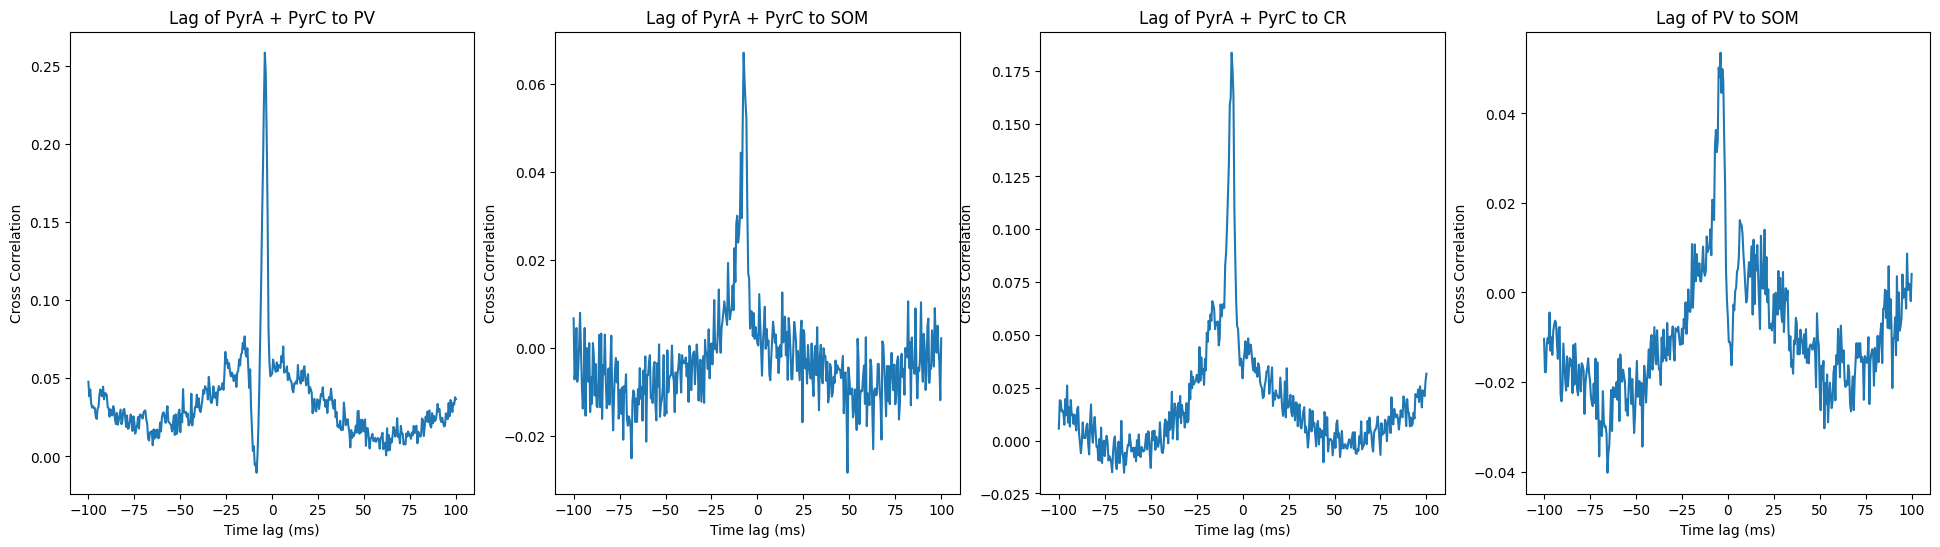

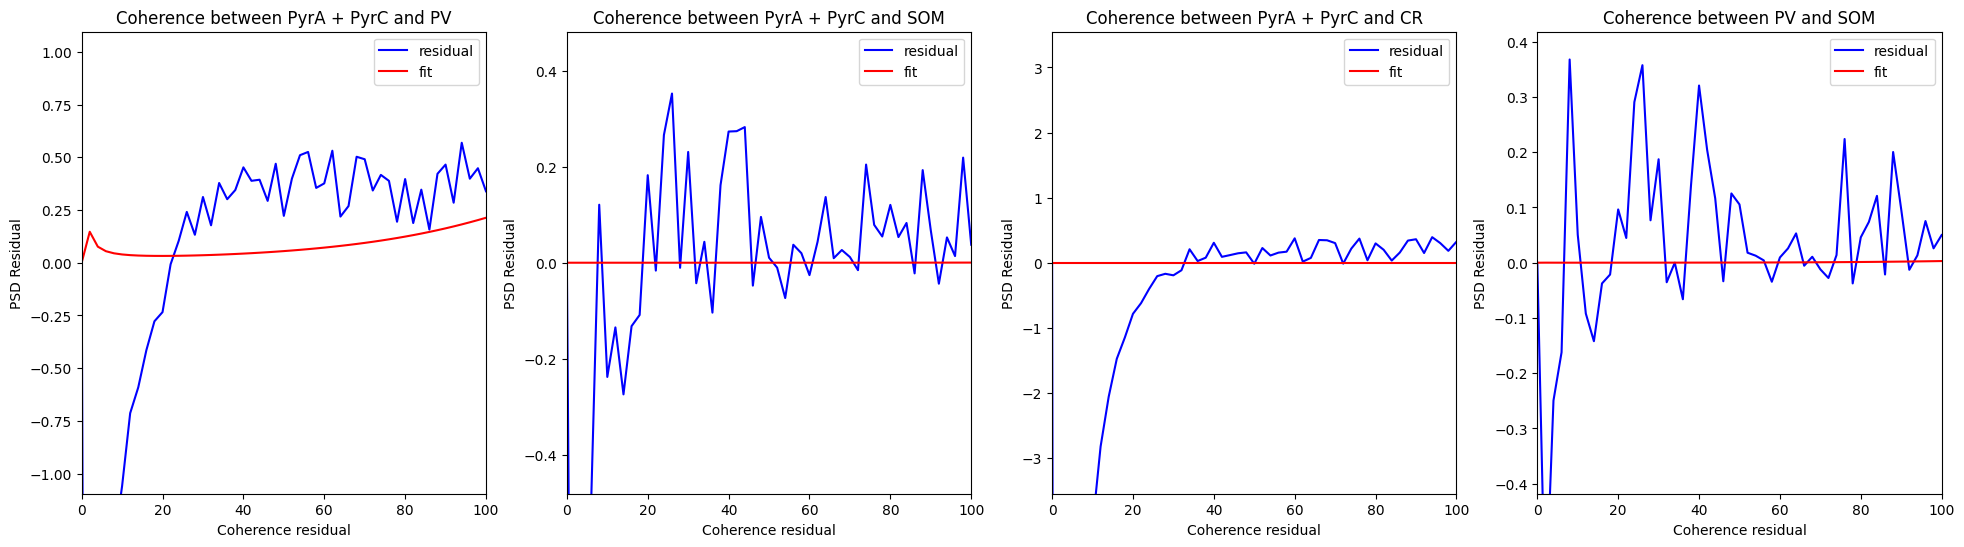

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import csv
import os
from bmtool.util import util
from bmtk.simulator import bionet

from Analysis.analysis import plot # imoporting analysis module enables import from model folder
from Analysis.build_input import get_populations, get_stim_cycle, t_start, on_time, off_time

TRIAL_NAME = "baseline"
RESULT_PATH = "simulation_results"
TRIAL_PATH = os.path.join(RESULT_PATH, TRIAL_NAME)
TRIAL_PATH = 'outputECP'
INPUT_PATH = os.path.join('..', 'input')

isbaseline = 'baseline' in TRIAL_NAME
if isbaseline:
    config = 'simulation_configECP_vpsi_homogenous.json'
elif 'const' in TRIAL_NAME:
    config = 'config_const.json'
else:
    config = 'config_short.json' if 'short' in TRIAL_NAME else 'config_long.json'

spike_file = os.path.join(TRIAL_PATH, 'spikes.h5')
config_file = config

pop_color = plot.pop_color
pop_names = plot.pop_names

conf = bionet.Config.from_json(config_file)
t_stop = conf['run']['tstop'] / 1000

nodes = util.load_nodes_from_config(config_file)
network_name = 'BLA'
cortex_df = nodes[network_name]
with h5py.File(spike_file) as f:
    spikes_df = pd.DataFrame({
        'node_ids': f['spikes'][network_name]['node_ids'],
        'timestamps': f['spikes'][network_name]['timestamps']
    })
    spikes_df.sort_values(by='timestamps', inplace=True, ignore_index=True)

windows = np.array([[0., t_stop]])

spikes_df['pop_name'] = cortex_df.loc[spikes_df['node_ids'], 'pop_name'].values
pop_spike = get_populations(spikes_df, pop_names)
id_column = 'node_ids'

#_, ax = plt.subplots(1, 1, figsize=(12, 8))
#plot.raster(pop_spike, pop_color, id_column=id_column, ax=ax)

#ax.legend(loc='upper right', framealpha=0.9, markerfirst=False)
#ax.set_xlim([0, 1.1 * spikes_df['timestamps'].max()])
#ax.set_ylim([cortex_df.index.min() - 1, cortex_df.index.max() + 1])
#plt.show()

fs = 2000.
dt = 1000 / fs
time = np.array([0, 1000 * t_stop, dt])
pop_rspk = {p: plot.pop_spike_rate(spk['timestamps'], time) for p, spk in pop_spike.items()}

SAVE_PATH = os.path.join(TRIAL_PATH, 'spike_rate.h5')
Cortex_nodes = get_populations(cortex_df, pop_names, only_id=True)

with h5py.File(SAVE_PATH, 'w') as f:
    f.create_dataset('time', data=time)
    grp = f.create_group('populations')
    for p, rspk in pop_rspk.items():
        pop = grp.create_group(p)
        pop.create_dataset('data', data=rspk)
        pop.attrs['number'] = len(Cortex_nodes[p])

spike_file = "spike_rate.h5"

with h5py.File(os.path.join(TRIAL_PATH, spike_file), 'r') as f:
    t_spk = np.arange(*f['time'])
    fs_spk = 1000 / f['time'][2] # sampling rate Hz
    pop_rspk = {p: g['data'][()] for p, g in f['populations'].items()}
    pop_num = {p: g.attrs['number'] for p, g in f['populations'].items()}

spike_groups = [['PyrA', 'PyrC'], ['PV'], ['SOM'],['CR']]
group_label = [' + '.join(spk_grp) for spk_grp in spike_groups]
spike_rate = []
for grp in spike_groups:
    rspk = np.zeros_like(t_spk)
    num = 0
    for p in grp:
        rspk += pop_rspk[p]
        num += pop_num[p]
    rspk *= fs / num
    rspk -= rspk.mean()
    spike_rate.append(rspk if np.any(rspk) else None)

grp_pairs = [[0, 1],[0,2],[0,3],[1,2]]
max_lag = 100. # ms
ngrps = len(grp_pairs)
i_start = int(t_start * fs_spk)

_, axs1 = plt.subplots(1, ngrps, figsize=(6 * ngrps, 6))
_, axs2 = plt.subplots(1, ngrps, figsize=(6 * ngrps, 6))
tseg = 0.5
plt_range = 100
plt_log=False

for i, grp_pair in enumerate(grp_pairs):
    if spike_rate[grp_pair[0]] is None or spike_rate[grp_pair[1]] is None:
        continue
    rspk1, rspk2 = spike_rate[grp_pair[0]][i_start:], spike_rate[grp_pair[1]][i_start:
    xcorr, xcorr_lags = plot.xcorr_coeff(rspk1, rspk2, dt=1000 / fs_spk, max_lag=max_lag, ax=axs1[i])
    axs1[i].set_xlabel('Time lag (ms)')
    axs1[i].set_title('Lag of %s to %s' % (group_label[grp_pair[0]], group_label[grp_pair[1]]))

    f, cxy = plot.get_coh_on_stimulus(spike_rate[grp_pair[0]], spike_rate[grp_pair[1]],
                                      fs_spk, on_time, off_time, t_start, t=t_spk, tseg=tseg)

    coh_results, fm = plot.fit_fooof(
        f, cxy, aperiodic_mode='fixed', dB_threshold=3., max_n_peaks=10,
        freq_range=600., peak_width_limits=100, report=False,
        plot=False, plt_range=plt_range, figsize=(8, 4))

    res_psd, res_fit = plot.psd_residual(
        f, cxy, coh_results, plot=True, plt_log=plt_log, plt_range=plt_range, ax=axs2[i])
    axs2[i].set_title('Coherence between %s and %s' % (group_label[grp_pair[0]], group_label[grp_pair[1]]))
    axs2[i].set_xlabel('Coherence residual')
    yl = axs2[i].get_ylim()
    axs2[i].set_ylim(bottom=max(yl[0], -yl[1]))
plt.show()

In [2]:
import scipy.signal as ss

path = "vpsi_inh_spikes.h5"
f = h5py.File(path)
vpsi = f['spikes/vpsi_inh/timestamps'][:]

spikes_location = 'outputECP/spikes.h5'
f = h5py.File(spikes_location)
spikes_df = pd.DataFrame({'node_ids':f['spikes']['BLA']['node_ids'],'timestamps':f['spikes']['BLA']['timestamps']}) 
pv_cells = range(800,893) #+1 to be inclusive of last cell
pv_cell_spikes = spikes_df[spikes_df['node_ids'].isin(pv_cells)]

spikes_location = 'outputECP/spikes.h5'
f = h5py.File(spikes_location)
spikes_df = pd.DataFrame({'node_ids':f['spikes']['BLA']['node_ids'],'timestamps':f['spikes']['BLA']['timestamps']}) 
pn_cells = range(0,800) #+1 to be inclusive of last cell
pn_cell_spikes = spikes_df[spikes_df['node_ids'].isin(pn_cells)]

def xcorr_coeff(x, y, max_lag=None, dt=1., plot=True, ax=None):
    x = np.asarray(x)
    y = np.asarray(y)
    xcorr = ss.correlate(x, y) / x.size / x.std() / y.std()
    xcorr_lags = ss.correlation_lags(x.size, y.size)
    if max_lag is not None:
        lag_idx = np.nonzero(np.abs(xcorr_lags) <= max_lag / dt)[0]
        xcorr = xcorr[lag_idx]
        xcorr_lags = xcorr_lags[lag_idx]

    if plot:
        if ax is None:
            _, ax = plt.subplots(1, 1)
        ax.plot(dt * xcorr_lags, xcorr)
        ax.set_xlabel('Lag')
        ax.set_ylabel('Cross Correlation')
    return xcorr, xcorr_lags

#xcorr_coeff(x=rspk1,y=rspk2,max_lag=200,dt=0.5)
#plt.plot(rspk2)
#plt.show()

[0.00000e+00 5.00000e-01 1.00000e+00 ... 1.49985e+04 1.49990e+04
 1.49995e+04]


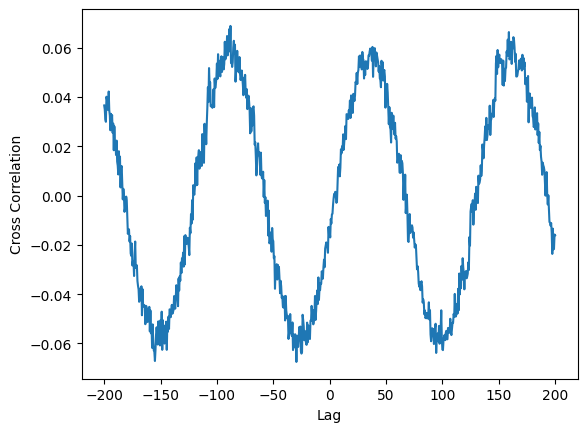

In [3]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from Analysis.analysis import plot

path = "vpsi_inh_spikes.h5"
f = h5py.File(path)
vpsi_spikes = f['spikes/vpsi_inh/timestamps'][:]

t_stop = 15
fs = 2000.
dt = 1000 / fs
time = np.array([0, 1000 * t_stop, dt])

vpsi_binned = plot.pop_spike_rate(vpsi_spikes, time)
spike_groups = [['vpsi']],
vpsi = []
print(t_spk)
for grp in spike_groups:
    rspk = np.zeros_like(t_spk)
    num = 100
    rspk += vpsi_binned
    rspk *= fs / num
    rspk -= rspk.mean()
    vpsi.append(rspk if np.any(rspk) else None)


xcorr_coeff(x=vpsi[0][i_start:],y=spike_rate[1],max_lag=200,dt=0.5) #spike_rate[1] is pv and spike_rate[0] is PN
plt.show()